In [12]:
"""Import all modules and load data from pickle file"""
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

pickle_file = 'SVHN_multi.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [13]:
"""Define accuracy function"""
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

print("Success")

Success


In [22]:
"""Construct Model"""
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
shape = [batch_size, image_size, image_size, num_channels]

# 7-layer CNN.
# C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# S2: sub-sampling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# S4: sub-sampling layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# F6: fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10

graph = tf.Graph()

with graph.as_default():
"""define weights and biases"""
  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
  layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
  layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

  s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
  s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
  s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
  s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
  s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')
  
  # Model.
  def model(data, keep_prob, shape):
    conv = tf.nn.conv2d(data,layer1_weights, [1,1,1,1],padding='VALID', name='C1')
    hidden = tf.nn.relu(conv + layer1_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
    conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
    hidden = tf.nn.relu(conv + layer2_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
    conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
    hidden = tf.nn.relu(conv + layer3_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

    logits1 = tf.matmul(reshape, s1_w) + s1_b
    logits2 = tf.matmul(reshape, s2_w) + s2_b
    logits3 = tf.matmul(reshape, s3_w) + s3_b
    logits4 = tf.matmul(reshape, s4_w) + s4_b
    logits5 = tf.matmul(reshape, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]
  
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9375, shape)
  # Define loss function.
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
  # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss) //static learning rate
  global_step = tf.Variable(0)
  #learning rate with exponential decay.
  learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95) 
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
  test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
  saver = tf.train.Saver()

num_steps = 5000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()  
  
    "to be used after first iteration"
  #saver.restore(session, "CNN_multi.ckpt")
  #print("Model restored.") 

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0): 
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,1:6]))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  save_path = saver.save(session, "CNN_multi.ckpt")
  print("Model saved in file: %s" % save_path)

Model restored.
Initialized
Minibatch loss at step 0: 1.298146
Minibatch accuracy: 94.7%
Validation accuracy: 91.3%
Minibatch loss at step 500: 1.086517
Minibatch accuracy: 93.4%
Validation accuracy: 90.7%
Minibatch loss at step 1000: 1.305291
Minibatch accuracy: 90.9%
Validation accuracy: 91.0%
Minibatch loss at step 1500: 1.264275
Minibatch accuracy: 94.1%
Validation accuracy: 91.3%
Minibatch loss at step 2000: 1.473126
Minibatch accuracy: 94.7%
Validation accuracy: 91.3%
Minibatch loss at step 2500: 1.052334
Minibatch accuracy: 94.7%
Validation accuracy: 91.4%
Minibatch loss at step 3000: 1.095857
Minibatch accuracy: 93.8%
Validation accuracy: 91.3%
Minibatch loss at step 3500: 1.570344
Minibatch accuracy: 90.0%
Validation accuracy: 91.5%
Minibatch loss at step 4000: 0.985313
Minibatch accuracy: 93.8%
Validation accuracy: 91.8%
Minibatch loss at step 4500: 1.301641
Minibatch accuracy: 93.8%
Validation accuracy: 91.7%
Test accuracy: 92.9%
Model saved in file: CNN_multi.ckpt


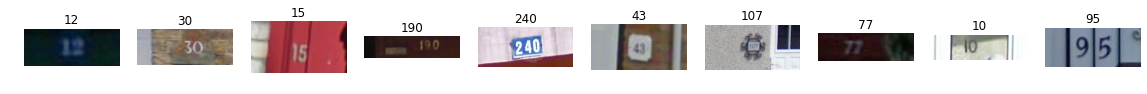

In [23]:
"""samples from test set"""
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[j,0]):
        house_num += str(test_labels[j,k+1])
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

In [24]:
"""reload learned model"""
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64

graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_test_dataset = tf.placeholder(tf.float32, shape=(10, 32, 32, 1))
  
  # Variables.
  layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
  layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
  layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

  s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
  s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
  s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
  s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
  s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
  s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')
  
  # Model.
  def model(data, keep_prob, shape):
    conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID', name='C1')
    hidden = tf.nn.relu(conv + layer1_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
    conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
    hidden = tf.nn.relu(conv + layer2_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
    conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
    hidden = tf.nn.relu(conv + layer3_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    logits1 = tf.matmul(reshape, s1_w) + s1_b
    logits2 = tf.matmul(reshape, s2_w) + s2_b
    logits3 = tf.matmul(reshape, s3_w) + s3_b
    logits4 = tf.matmul(reshape, s4_w) + s4_b
    logits5 = tf.matmul(reshape, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]
  
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_test_dataset, 1, [10, 32, 32, 1])

  predict = tf.pack([tf.nn.softmax(logits1),tf.nn.softmax(logits2),tf.nn.softmax(logits3),\
                         tf.nn.softmax(logits4),tf.nn.softmax(logits5)])
  test_prediction = tf.transpose(tf.argmax(predict, 2))
  saver = tf.train.Saver()

with tf.Session(graph=graph) as session:
  saver.restore(session, "CNN_multi.ckpt")
  print("Model restored.")  

  print('Initialized')
  test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
  print(test_prediction)

Model restored.
Initialized
[[ 1  2 10 10 10]
 [ 3  0 10 10 10]
 [ 1  5 10 10 10]
 [ 1  9  0 10 10]
 [ 2  4  0 10 10]
 [ 4  3 10 10 10]
 [ 1  8  8 10 10]
 [ 7  7 10 10 10]
 [ 1  0 10 10 10]
 [ 9  1  5 10 10]]


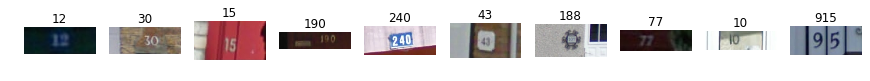

In [25]:
"""prediction over selected test samples"""
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)



for i, j in enumerate(im_samples):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(np.sum(test_prediction[i,:] != 10)):
        house_num += str(test_prediction[i,k])

    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)